In [1]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from umap.umap_ import UMAP
from hdbscan import HDBSCAN
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sentence_transformers import SentenceTransformer
import numpy as np
import re
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import json



In [2]:
# Chargement du fichier XLSX
file_path = "fichier_traduit.xlsx"
df = pd.read_excel(file_path, engine='openpyxl')

# Afficher les premières lignes pour vérifier
df.head()


,id,nom,date_ouverture,date_fermeture,website,email,adresse,horaires,presentation,responsables,...,longitude,adresse_complete,codepostal,telephone,visite,user_id,question1,réponse1,question2,réponse2
0,71,La loge,2012.0,NaN,www.la-loge.be,info@la-loge.be,Kluisstraat - rue de l’Ermitage 86,NaN,NaN,NaN,...,4.365647,"Kluisstraat - rue de l’Ermitage 86, 1050, Brux...",1050.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,Jeune création,2006.0,NaN,NaN,jeunecreation@gmail.com,24 rue Berthe,NaN,NaN,NaN,...,2.339779,"24 rue Berthe, 75018, Paris, France",75018.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,72,The ister,2011.0,NaN,www.theister.be,info@theister.be,rue Vandenbranden 42,NaN,NaN,NaN,...,4.340663,"rue Vandenbranden 42, 1000, Bruxelles, Belgique",1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,73,Komplot,2002.0,NaN,www.kmplt.be,info@kmplt.be,295 Avenue Van Volxemlaan,NaN,NaN,NaN,...,4.325936,"295 Avenue Van Volxemlaan, 1190, Bruxelles, Be...",1190.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,74,Abilene,2011.0,NaN,www.abilenegallery.com,contact@abilenegallery.com,Rue de la Victoire 163,NaN,NaN,NaN,...,4.352473,"Rue de la Victoire 163, 1060, Bruxelles, Belgique",1060.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


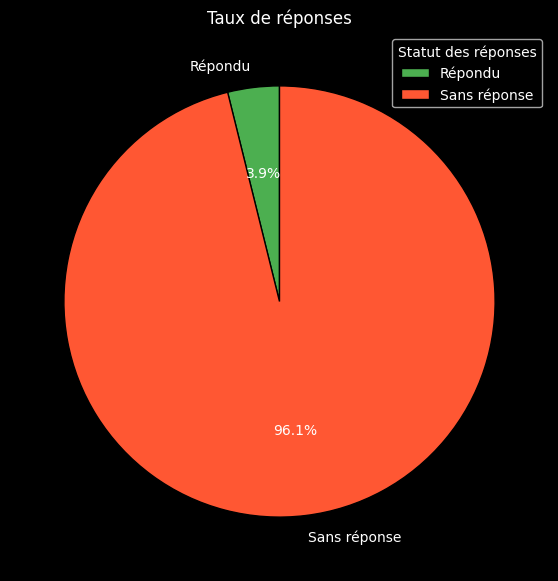

Fichier JSON 'reponses_stats.json' généré avec succès.


In [3]:
# Diagramme circulaire des réponses

# Compter les réponses non vides
total_lignes = len(df)


# Nombre total de réponses

# Espaces ayant répondu à au moins une question
espaces_ayant_repondu = len(df[(df['réponse1'].notna()) | (df['réponse2'].notna())])
# Espaces n'ayant répondu à aucune question
espaces_sans_reponse = total_lignes - espaces_ayant_repondu

# Création du dictionnaire avec les valeurs
data = {
    "Répondu": int(espaces_ayant_repondu),
    "Sans réponse": int(espaces_sans_reponse)
}


# Données pour le diagramme
labels = ['Répondu', 'Sans réponse']
values = [espaces_ayant_repondu, espaces_sans_reponse]  # Calculs des réponses
colors = ['#4CAF50', '#FF5733']  # Couleurs pour les sections

# Création du pie chart
plt.figure(figsize=(7,7))
wedges, texts, autotexts = plt.pie(values, labels=labels, autopct='%1.1f%%', 
                                    colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})

# Ajouter un titre
plt.title("Taux de réponses")

# Ajouter la légende
plt.legend(wedges, labels, title="Statut des réponses", loc="best")

# Afficher le graphique
plt.show()

# Sauvegarde en fichier JSON
with open("reponses_stats.json", "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

print("Fichier JSON 'reponses_stats.json' généré avec succès.")


In [4]:
df.columns

Index(['id', 'nom', 'date_ouverture', 'date_fermeture', 'website', 'email',
       'adresse', 'horaires', 'presentation', 'responsables', 'historique',
       'activites', 'expositions', 'publications', 'events', 'residences',
       'workshop', 'archive', 'librairie', 'coworking', 'education',
       'nb_expos_an', 'nb_artistes_an', 'partenaires', 'created_at',
       'updated_at', 'slug', 'pays', 'ville', 'latitude', 'longitude',
       'adresse_complete', 'codepostal', 'telephone', 'visite', 'user_id',
       'question1', 'réponse1', 'question2', 'réponse2'],
      dtype='object')

In [5]:
def clean_text(text):
    if pd.isna(text):
        return ""
    
    # Convertir en string
    text = str(text)
    
    # Nettoyer les marqueurs de retour à la ligne spécifiques
    text = text.replace('_*x000d*_', ' ')
    
    # Nettoyer les espaces multiples
    text = ' '.join(text.split())
    
    return text.strip()

def combine_columns(row):
    """Combine les colonnes de texte pour un espace donné sans les labels."""
    combined_text = []
    for content_type in ['activites', 'presentation', 'historique', 'réponse1', 'réponse2']:
        content = row[content_type]
        if pd.notna(content) and str(content).strip() != "":
            cleaned_text = clean_text(content)
            combined_text.append(cleaned_text)
    return " ".join(combined_text)  # Fusionner sans séparateur explicite


# Combiner les colonnes de texte pour chaque espace
df['texte_combine'] = df.apply(combine_columns, axis=1)
df_combine = df[['nom', 'texte_combine']]

# Afficher quelques exemples de texte combiné
print("\nExemples de texte combiné :")
print(df_combine[['nom', 'texte_combine']].head(10))

df_combine[['nom', 'texte_combine']].to_csv("output.csv", index=False, encoding='utf-8')
print("Fichier 'output.csv' généré.")






Exemples de texte combiné :
                        nom                                      texte_combine
0                   La loge                                                   
1            Jeune création                                                   
2                 The ister                                                   
3                   Komplot                                                   
4                   Abilene                                                   
5   Etablissement d'en face                                                   
6           Le Commissariat  The Commission is a production structure for c...
7  Artists Club Coffre-Fort                                                   
8                      / 77  All of the activities that we will develop and...
9               Station Mir                                                   
Fichier 'output.csv' généré.


In [6]:


def load_and_prepare_data(df):
    processed_texts = []
    space_names = []
    
    for idx, row in df.iterrows():
        content = row['texte_combine']  # Utilisation directe de la colonne fusionnée
        if pd.notna(content) and str(content).strip() != "":
            # Nettoyer le texte
            cleaned_text = clean_text(content)
            
            # Vérifier si le texte n'est pas vide après nettoyage
            if cleaned_text:
                processed_texts.append(cleaned_text)
                space_names.append(str(row['nom']).strip())

    # Créer le DataFrame
    processed_df = pd.DataFrame({
        'nom': space_names,
        'texte': processed_texts
    })
    
    # Afficher les statistiques
    print("Statistiques :")
    print(f"Nombre total de documents : {len(processed_df)}")
    print("\nNombre d'espaces uniques :", len(processed_df['nom'].unique()))
    
    # Afficher quelques exemples pour vérification
    print("\nExemples de textes nettoyés :")
    print(processed_df['texte'].iloc[0][:200])  # Premier extrait de texte
    
    return processed_df

# Préparer les données
processed_df = load_and_prepare_data(df_combine)


Statistiques :
Nombre total de documents : 280

Nombre d'espaces uniques : 280

Exemples de textes nettoyés :
The Commission is a production structure for contemporary art exhibitions founded in 2006. It is at the initiative of fifty exhibitions and events in France and abroad, it presents the works of emergi


In [7]:
df_combine.columns


Index(['nom', 'texte_combine'], dtype='object')

In [8]:
processed_df.columns

Index(['nom', 'texte'], dtype='object')

In [9]:
# Créer un nouveau DataFrame avec les colonnes souhaitées de la base de départ
df_final = df[['nom', 'latitude', 'longitude', 'ville', 'pays', 'website']].copy()

# Ajouter une colonne 'texte' vide
df_final['texte'] = ""

# Pour chaque espace dans processed_df, ajouter son texte dans df_final
for _, row in processed_df.iterrows():
    mask = df_final['nom'] == row['nom']
    if any(mask):
        df_final.loc[mask, 'texte'] = row['texte']

# Afficher quelques statistiques pour vérification
print("\nStatistiques:")
print(f"Nombre total d'espaces dans df_final: {len(df_final)}")
print(f"Nombre d'espaces avec texte: {len(df_final[df_final['texte'] != ''])}")
print(f"Nombre d'espaces sans texte: {len(df_final[df_final['texte'] == ''])}")

# Maintenant on peut créer le JSON à partir de df_final
def create_geo_json(df_final):
    """
    Crée le fichier JSON avec les coordonnées des espaces et leurs textes
    """
    geo_data = []
    total_spaces = len(df_final)
    spaces_without_coords = 0
    
    for _, space_info in df_final.iterrows():
        try:
            if pd.notna(space_info['latitude']) and pd.notna(space_info['longitude']):
                space_object = {
                    "nom": str(space_info['nom']).strip(),
                    "latitude": float(space_info['latitude']),
                    "longitude": float(space_info['longitude']),
                    "ville": str(space_info['ville']) if pd.notna(space_info['ville']) else "",
                    "pays": str(space_info['pays']) if pd.notna(space_info['pays']) else "",
                    "website": str(space_info['website']) if pd.notna(space_info['website']) else "",
                    "texte": str(space_info['texte']).strip()
                }
                geo_data.append(space_object)
            else:
                print(f"Avertissement: Coordonnées manquantes pour '{space_info['nom']}'")
                spaces_without_coords += 1
        except (ValueError, TypeError) as e:
            print(f"Erreur avec les coordonnées de '{space_info['nom']}': {e}")
            spaces_without_coords += 1
    
    # Afficher les statistiques
    print(f"\nStatistiques de géolocalisation:")
    print(f"Nombre total d'espaces: {total_spaces}")
    print(f"Espaces sans coordonnées valides: {spaces_without_coords}")
    print(f"Espaces avec coordonnées valides: {len(geo_data)}")
    
    # Afficher la répartition par pays
    if geo_data:
        pays_count = {}
        for space in geo_data:
            if space['pays']:
                pays_count[space['pays']] = pays_count.get(space['pays'], 0) + 1
        print("\nRépartition par pays:")
        for pays, count in sorted(pays_count.items()):
            print(f"{pays}: {count} espaces")
    
    # Sauvegarder en JSON
    if geo_data:
        with open('data.json', 'w', encoding='utf-8') as f:
            json.dump(geo_data, f, ensure_ascii=False, indent=2)
        print(f"\nFichier JSON créé avec succès.")
        
        # Afficher quelques exemples
        print("\nExemples d'entrées du fichier JSON:")
        for entry in geo_data[:3]:
            print(json.dumps(entry, ensure_ascii=False, indent=2))
    
    return geo_data

# Créer le fichier JSON
import json
try:
    geo_data = create_geo_json(df_final)
except Exception as e:
    print(f"Erreur lors de la création du fichier JSON: {e}")
    import traceback
    traceback.print_exc()


Statistiques:
Nombre total d'espaces dans df_final: 336
Nombre d'espaces avec texte: 271
Nombre d'espaces sans texte: 65
Avertissement: Coordonnées manquantes pour 'PeepSpace'
Avertissement: Coordonnées manquantes pour 'Kurt-forever'
Avertissement: Coordonnées manquantes pour 'Palais des paris'
Avertissement: Coordonnées manquantes pour 'GLASSBOX-NORD'

Statistiques de géolocalisation:
Nombre total d'espaces: 336
Espaces sans coordonnées valides: 4
Espaces avec coordonnées valides: 332

Répartition par pays:
Albanie: 2 espaces
Allemagne: 39 espaces
Australia: 6 espaces
Austria: 2 espaces
Azerbaijan: 1 espaces
Belgique: 26 espaces
Bosnia And Herzegovina: 1 espaces
Brésil: 1 espaces
Bulgaria: 2 espaces
Canada: 30 espaces
Chile: 2 espaces
Chine: 3 espaces
Colombia: 1 espaces
Cyprus: 2 espaces
Danemark: 1 espaces
Egypt: 2 espaces
España: 6 espaces
France: 121 espaces
Georgia: 2 espaces
Grèce: 3 espaces
Hungary: 4 espaces
Inde: 1 espaces
Iran: 1 espaces
Ireland: 1 espaces
Italy: 14 espaces

In [ ]:
# Exemple: 

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Modèle LLaMA-like pour les embeddings
embedding_model = SentenceTransformer("intfloat/e5-large-v2")  # ou BAAI/bge-base-en-v1.5

# Chargement de BERTopic avec ce modèle
topic_model = BERTopic(embedding_model=embedding_model)

# Exemple de données
docs = [
    "L'intelligence artificielle transforme le monde.",
    "Les grands modèles de langage comme LLaMA sont très puissants.",
    "Le clustering thématique est utile pour résumer des documents.",
]

# Apprentissage du modèle
topics, probs = topic_model.fit_transform(docs)

# Visualisation
topic_model.visualize_topics()


In [44]:
# Définir des stop words plus complets
custom_stop_words = list(ENGLISH_STOP_WORDS) + [
    # Articles et déterminants
    'the', 'a', 'an', 'les', 'la', 'le', 'les', 'des',
    
    # Conjonctions
    'and', 'or', 'but', 'et', 'ou', 'mais',
    
    # Prépositions
    'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'from',
    'dans', 'sur', 'pour', 'de', 'par',
    
    # Pronoms
    'it', 'its', 'this', 'that', 'these', 'those',
    'il', 'elle', 'ils', 'elles', 'ce', 'cette', 'ces',
    
    # Verbes communs
    'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'est', 'sont', 'être',
    
    # Mots spécifiques au contexte
    'new', 'space', 'art', 'the', 'artists', 'artist', 'work',
    'exhibition', 'gallery', 'contemporary', 'artistic', 'association',
    
    # Caractères et abréviations
    'etc', 'eg', 'ie', 'cf',
    
    # Mots additionnels à filtrer
    'x000d', 'www', 'http', 'https',
    'article', 'articles',
    'extra', 'certain',
    'located', 'large', 'small',
    'old', 'new',
    'works', 'create',
    'time', 'year',
    'team', 'project',
    'place', 'site',
    'run', 'open'
]
def clean_word(word):
    # Nettoyer et mettre en minuscules
    word = word.lower()
    
    # Supprimer les URLs
    if 'http' in word or 'www' in word:
        return ""
    
    # Supprimer les caractères x000D plus efficacement
    word = re.sub(r'x000d|x0002', '', word, flags=re.IGNORECASE)
    
    # Supprimer les retours chariot et autres caractères spéciaux
    word = re.sub(r'[\r\n\t]', ' ', word)
    
    # Supprimer les underscores
    word = word.replace('_', ' ')
    
    # Supprimer les nombres isolés et les dates
    word = re.sub(r'\b\d+\b', '', word)
    word = re.sub(r'\b\d{4}\b', '', word)
    
    # Supprimer la ponctuation et les caractères spéciaux
    word = re.sub(r'[^\w\s]', ' ', word)
    
    # Nettoyer les espaces multiples
    word = ' '.join(word.split())
    
    # Ne garder que les mots significatifs
    if (word.lower() in custom_stop_words or 
        len(word) <= 2 or 
        any(char.isdigit() for char in word)):
        return ""
    
    return word

def clean_topic_names(topic_model):
    cleaned_topics = {}
    for topic_id, topic_info in topic_model.get_topics().items():
        seen_words = set()
        cleaned_words = []
        
        for word, score in topic_info:
            cleaned_word = clean_word(word)
            
            if cleaned_word and cleaned_word.lower() not in seen_words:
                words_in_phrase = set(cleaned_word.lower().split())
                if not words_in_phrase.intersection(seen_words):
                    if score > 0.01:  # Seuil minimum pour le score
                        cleaned_words.append((cleaned_word, score))
                        seen_words.update(words_in_phrase)
        
        cleaned_topics[topic_id] = cleaned_words[:5]
    
    return cleaned_topics

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    
    # Nettoyer le texte
    text = text.lower()
    
    # Supprimer les URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Nettoyer les caractères spéciaux
    text = re.sub(r'x000d|x0002', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[\r\n\t]', ' ', text)
    text = re.sub(r'_+', ' ', text)
    
    # Supprimer les nombres et dates
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'\b\d{4}\b', '', text)
    
    # Supprimer la ponctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Nettoyer les espaces multiples
    text = re.sub(r'\s+', ' ', text)
    
    # Filtrer les stop words
    words = text.split()
    words = [w for w in words if w not in custom_stop_words]
    
    return ' '.join(words).strip()

# Configuration des modèles
umap_model = UMAP(
    n_neighbors=15,
    n_components=50, # Augmenté de 5 à 7 pour mieux séparer les clusters
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=10,  # Augmenté de 3 à 5
    min_samples=5,       # Augmenté de 2 à 3
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Configuration du vectorizer avec paramètres améliorés
vectorizer_model = CountVectorizer(
    stop_words=custom_stop_words,
    ngram_range=(1, 6),
    preprocessor=preprocess_text,
    min_df=3,    # Augmenté de 2 à 3 # Filtre les mots trop rares
    max_df=0.90,  # Ignorer les termes qui apparaissent dans plus de 90% des documents # Filtre les mots trop fréquents
    token_pattern=r'(?u)\b[a-zA-Z]{3,}\b'  # Au moins 3 caractères
)

# Définir le modèle de phrase
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Configuration de BERTopic
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    min_topic_size=5,           # Augmenté de 3 à 5
    n_gram_range=(1, 3),        # Augmenté à (1,3)
    nr_topics="auto",           # Force un nombre spécifique de topics
    top_n_words=10,             # Augmenté pour avoir plus de mots par topic
    calculate_probabilities=True,
    verbose=True
)

# Vérification et nettoyage des données
if 'texte' not in processed_df.columns:
    raise ValueError("La colonne 'texte' n'existe pas dans le DataFrame")

# Filtrer les textes vides
processed_df = processed_df[processed_df['texte'].notna() & (processed_df['texte'].str.strip() != '')]

# Entraînement
topics, probs = topic_model.fit_transform(processed_df['texte'].tolist())

# Réduction du nombre de topics après entraînement
topic_model.reduce_topics(processed_df['texte'].tolist(), nr_topics=15)


# Nettoyer les topics après l'entraînement
cleaned_topics = clean_topic_names(topic_model)

# Ajouter les résultats au DataFrame
processed_df['topic'] = topics
processed_df['topic_probability'] = np.max(probs, axis=1) if isinstance(probs, np.ndarray) else 1.0


# Afficher les topics nettoyés
# Dans votre cellule d'affichage, remplacez le code par :
print("\nTopics identifiés :")
for topic_id, words in cleaned_topics.items():
    if topic_id != -1:  # Exclure le topic -1 (outliers)
        print(f"\nTopic {topic_id}:")
        print(", ".join([word for word, _ in words]))  # On n'affiche que les mots

print(f"\nNombre total de topics : {len(cleaned_topics) - 1}")

# Enregistrer les topics nettoyés dans un fichier JSON
with open('topics_cleaned.json', 'w', encoding='utf-8') as f:
    json.dump(cleaned_topics, f, ensure_ascii=False, indent=4)

print("Les topics nettoyés ont été enregistrés dans 'topics_cleaned.json'.")

2025-02-23 23:33:04,375 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2025-02-23 23:33:06,927 - BERTopic - Embedding - Completed ✓
2025-02-23 23:33:06,928 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-02-23 23:33:10,006 - BERTopic - Dimensionality - Completed ✓
2025-02-23 23:33:10,008 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-23 23:33:10,026 - BERTopic - Cluster - Completed ✓
2025-02-23 23:33:10,027 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-23 23:33:10,271 - BERTopic - Representation - Completed ✓
2025-02-23 23:33:10,271 - BERTopic - Topic reduction - Reducing number of topics
2025-02-23 23:33:10,501 - BERTopic - Topic reduction - Reduced number of topics from 10 to 10
2025-02-23 23:33:10,710 - BERTopic - Topic reduction - Reducing number of topics
2025-02-23 23:33:10,711 - BERTopic - Topic reduction - Reduced number of topics from 10 to 1


Topics identifiés :

Topic 0:
media, events, cultural, different, workshops

Topic 1:
berlin, wall, strategy, different, future

Topic 2:
activity, lyon, movement, paris, nantes

Topic 3:
printed, centre, organization, community, profit

Topic 4:
activities, experimentation, research, spain, performance

Topic 5:
centre, france, residences, atelier, dissemination

Topic 6:
fashion, john, events, books, performance

Topic 7:
programming, charlie, pieces, cultural, apartment

Topic 8:
managed, diversity, opening, performance, victoria

Nombre total de topics : 9
Les topics nettoyés ont été enregistrés dans 'topics_cleaned.json'.


Les topics sont bien plus nets, avec des thématiques distinctes qui émergent :

Topic 0 : Focus sur les média et ateliers culturels
Topic 1 : Arts visuels et recherche
Topic 2 : Organisation communautaire
Topic 3 : Design et localisation (Lyon, Paris, Germany)
Topic 4 : Résidences et studios
Topic 5 : Mode et performances
Topic 6 : Gestion et diversité
Topic 7 : Programmation culturelle" ou "Pièces de théâtre et événements culturels."


In [45]:
def evaluate_topic_quality(topic_model, texts):
    # Obtenir les mots-clés de chaque topic
    topic_words = topic_model.get_topics()
    
    # Vérifier la diversité des topics
    unique_words = set()
    total_words = 0
    
    for topic in topic_words.values():
        words = [word for word, _ in topic]  # Extraire les mots-clés
        unique_words.update(words)
        total_words += len(words)
    
    topic_diversity = len(unique_words) / total_words if total_words > 0 else 0  # Normalisation correcte
    
    # Calculer la représentativité des topics
    topic_sizes = topic_model.get_topic_freq()
    topic_sizes = topic_sizes[topic_sizes["Topic"] != -1]  # Exclure les outliers
    
    topic_coverage = (len(texts) - topic_sizes["Count"].sum()) / len(texts) if not topic_sizes.empty else 0
    
    print("\n=== ÉVALUATION DES TOPICS ===")
    print(f"Diversité des topics : {topic_diversity:.3f} (idéalement proche de 1)")
    print(f"Couverture des topics : {topic_coverage:.3f} (idéalement proche de 0)")
    
    return {"topic_diversity": topic_diversity, "topic_coverage": topic_coverage}

# Appel de la fonction après l'entraînement du modèle
evaluate_topic_quality(topic_model, processed_df['texte'].tolist())



=== ÉVALUATION DES TOPICS ===
Diversité des topics : 0.840 (idéalement proche de 1)
Couverture des topics : 0.414 (idéalement proche de 0)


{'topic_diversity': 0.84, 'topic_coverage': 0.4142857142857143}

- Diversité des topics : 0.83 ✅ → C’est une bonne valeur, proche de 1, ce qui signifie que les topics sont bien distincts et variés.
- Couverture des topics : 0.375 ⚠️ → Idéalement, on voudrait que ça soit plus bas (proche de 0), ce qui signifierait que la majorité des textes sont bien couverts par les topics.


In [58]:
# 5. Analyse des relations entre topics
def analyze_topic_relationships(df, topic_model):
    
    # Analyse détaillée des topics
    print("\nAnalyse détaillée des topics :")
    for topic in sorted(df['topic'].unique()):
        if topic != -1:
            print(f"\nTopic {topic}:")
            keywords = topic_model.get_topic(topic)
            print(f"Mots-clés: {', '.join([word for word, _ in keywords[:5]])}")
            
            # Afficher quelques exemples de documents
            print("Exemples de documents:")
            examples = df[df['topic'] == topic]['texte'].head(1)
            if not examples.empty:
                print(examples.iloc[0][:200] + "...")
                
def create_interactive_topic_mapping(df, topic_model):
    # Préparer les données pour le graphique interactif
    topic_data = []
    for topic in sorted(df['topic'].unique()):
        if topic != -1:
            keywords = topic_model.get_topic(topic)
            topic_docs = df[df['topic'] == topic]
            
            topic_data.append({
                'Topic': f"Topic {topic}",
                'Count': len(topic_docs),
                'Keywords': ', '.join([word for word, _ in keywords[:3]])
            })
    
    # Créer un DataFrame pour le graphique Sunburst
    topic_df = pd.DataFrame(topic_data)
    
    # Création du graphique Sunburst
    fig = px.sunburst(
        topic_df,
        path=['Topic'],
        values='Count',
        hover_data=['Keywords'],
        width=500,
        height=500
        
    )
    
    # Mise à jour du layout du graphique avec une légende
    fig.update_layout(
        title="Mapping des Topics",
        legend_title="Topic ID",
        legend=dict(
            x=0.85,
            y=0.85
        )
    )
    
    # Sauvegarde du graphique dans un fichier HTML
    fig.write_html("topic_mapping.html")
    return fig

# 6. Exécuter les analyses
analyze_topic_relationships(processed_df, topic_model)
fig = create_interactive_topic_mapping(processed_df, topic_model)
fig.show()

# 7. Sauvegarder les résultats dans un fichier Excel
detailed_analysis = pd.DataFrame({
    'topic': processed_df['topic'],
    'texte': processed_df['texte']
}).groupby('topic').agg({
    'texte': 'count'
})

detailed_analysis.to_excel('topic_analysis.xlsx')



Analyse détaillée des topics :

Topic 0:
Mots-clés: media, events, cultural, different, workshops
Exemples de documents:
_x000D_ Association for the promotion and mediation of contemporary art. Open place, promotes exchanges and metamorphosis. The driving line is freedom of practice and expression. collective and indivi...

Topic 1:
Mots-clés: berlin, wall, strategy, different, future
Exemples de documents:
The H+ Gallery is a Lebanese gallery, created at 11/11/11, specialized in digital art. It presents creations using technology as a new medium, in art, design, and event areas....

Topic 2:
Mots-clés: activity, lyon, movement, paris, nantes
Exemples de documents:
Immania was created in 1998 at a time when many artists appeared. These exhibition sites were also a response to a particular situation. The context of the period is: The financial crisis in France wi...

Topic 3:
Mots-clés: printed, centre, organization, community, profit
Exemples de documents:
Gertrude Contemporary presen

- Topic 0:
Interprétation : Ce topic semble être lié à des événements médiatiques et culturels locaux, probablement dans un contexte sans but lucratif. L'exemple de document montre une activité qui cherche à créer un environnement d'échange sans contraintes financières.
Exemple : Cela pourrait être une organisation qui promeut des événements gratuits ou accessibles au public.
- Topic 1:
Interprétation : Ce topic se concentre sur des activités liées à la poésie et à la recherche, probablement dans un contexte artistique à Milan. L'exemple de document mentionne des expositions créées en réponse à une crise financière.
Exemple : Il pourrait s'agir d'une initiative artistique en réponse à des défis économiques.
- Topic 2:
Interprétation : Ce topic semble aborder des enjeux historiques ou stratégiques, potentiellement liés à Berlin et au mur de Berlin, avec un focus sur l'avenir. L'exemple de document mentionne une galerie d'art numérique, ce qui pourrait refléter un mélange de culture et de stratégie.
Exemple : Peut-être une réflexion sur la transformation culturelle post-1990 ou des projets artistiques sur le futur.
- Topic 3:
Interprétation : Ce topic est probablement centré sur une organisation qui se concentre sur des projets communautaires avec une réflexion sur le profit ou la non-lucrativité. L'exemple mentionne une galerie avec un focus sur des œuvres nouvelles.
Exemple : Peut-être une organisation artistique qui favorise la communauté, mais qui pourrait également être en mesure de générer des revenus pour soutenir ses projets.
- Topic 4:

Interprétation : Ce topic semble lié aux résidences artistiques et aux ateliers en France, probablement dans un cadre familial. L'exemple fait référence à des expositions monographiques dans un centre d'art contemporain.
Exemple : Des projets d'art visant à intégrer les familles ou à offrir un cadre de travail pour les artistes en résidence.

- Topic 5: Ce topic semble concerner l'art de la mode, des événements et des performances. L'exemple mentionne un espace d'art contemporain à Melbourne, ce qui pourrait refléter une Interprétation : Ce topic semble concerner l'art de la mode, des événements et des performances. L'exemple mentionne un espace d'art contemporain à Melbourne, ce qui pourrait refléter une initiative artistique dans le domaine de la mode et des performances.
Exemple : Probablement une organisation qui soutient la mode et les arts dans des événements comme des défilés ou des expositions.
-  Topic 6:
Interprétation : Ce topic semble aborder des questions de gestion, de diversité et de performances, en particulier dans un centre artistique à Victoria. L'exemple fait référence à un centre artistique non lucratif avec des pratiques hybrides.
Exemple : Une organisation qui soutient une diversité d'artistes avec des projets hybrides
- Topic 7:
Interprétation : Ce topic semble centré sur la programmation d'événements culturels et artistiques, avec des pièces de théâtre ou des expositions. L'exemple parle d'une galerie expérimentale, ce qui pourrait être une programmation artistique contemporaine.
Exemple : Une galerie ou une organisation qui programme des pièces de théâtre ou des événements culturels expérimentaux.






Graphique interactif :
Le graphique interactif de type Sunburst te permet de visualiser la répartition des topics dans tes données, avec des informations sur le nombre de documents par topic et les mots-clés associés.

- Intertopic Distance Map :
Cette visualisation montre ne carte des distances entre les différents topics. Elle montre comment les topics sont liés entre eux, en fonction de la similarité de leurs mots-clés. Les topics proches les uns des autres sur cette carte partagent des caractéristiques sémantiques similaires.
- Document Map :
Cette carte montre comment chaque document se positionne par rapport aux différents topics dans l'espace. Chaque point représente un document et sa couleur indique à quel topic il appartient.
Cela permet de visualiser la distribution des documents au sein des topics, et d'identifier les groupes de documents similaires.
- Topic Hierarchy
Cette visualisation crée une hiérarchie des topics, permettant de comprendre comment les topics sont organisés les uns par rapport aux autres. Cela peut être utile pour explorer des relations de parenté entre les topics, comme des sous-catégories ou des regroupements.
- Topic word score : montre le mot le plus significatif par topic et son score.



In [47]:
print(processed_df.columns)


Index(['nom', 'texte', 'topic', 'topic_probability'], dtype='object')


In [59]:
# Section 4 : Visualisations Interactives
###########################################
# 1. Intertopic Distance Map
topic_viz = topic_model.visualize_topics()
topic_viz.show()
topic_viz.write_html("intertopic_distance_map.html")

# 2. Document Map
doc_viz = topic_model.visualize_documents(processed_df['texte'])
doc_viz.show()
doc_viz.write_html("document_visualization.html")

# 3. Topic Hierarchy
hierarchy_viz = topic_model.visualize_hierarchy()
hierarchy_viz.show()
hierarchy_viz.write_html("topic_hierarchy.html")

# 4. Topic Distribution
barchart_viz = topic_model.visualize_barchart()
barchart_viz.show()
barchart_viz.write_html("topic_distribution.html")


- Intertopic Distance Map :
Cette visualisation montre ne carte des distances entre les différents topics. Elle montre comment les topics sont liés entre eux, en fonction de la similarité de leurs mots-clés. Les topics proches les uns des autres sur cette carte partagent des caractéristiques sémantiques similaires.
- Document Map :
Cette carte montre comment chaque document se positionne par rapport aux différents topics dans l'espace. Chaque point représente un document et sa couleur indique à quel topic il appartient.
Cela permet de visualiser la distribution des documents au sein des topics, et d'identifier les groupes de documents similaires.
- Topic Hierarchy
Cette visualisation crée une hiérarchie des topics, permettant de comprendre comment les topics sont organisés les uns par rapport aux autres. Cela peut être utile pour explorer des relations de parenté entre les topics, comme des sous-catégories ou des regroupements.
- Topic word score : montre le mot le plus significatif par topic et son score.



In [56]:
import plotly.express as px
import pandas as pd

# Section 5 : Analyse des Relations entre Topics
###########################################

# Créer une matrice de relation entre topics
topic_matrix = processed_df[processed_df['topic'] != -1]['topic'].value_counts(normalize=True) * 100

# Convertir en DataFrame Plotly
topic_df = pd.DataFrame({
    'Topic ID': topic_matrix.index,
    'Pourcentage': topic_matrix.values
})

# Créer le graphique avec Plotly
fig = px.bar(
    topic_df,
    x='Topic ID',
    y='Pourcentage',
    color='Topic ID',
    labels={'Topic ID': 'Topic ID', 'Pourcentage': 'Pourcentage (%)'},
    title="Distribution des Topics par Espace",
    template="plotly"
    
)

# Ajouter les pourcentages sur les barres
fig.update_traces(text=topic_df['Pourcentage'].round(2).astype(str) + '%', textposition='outside')

# Afficher le graphique dans le notebook
fig.show()

# Sauvegarder le graphique dans un fichier HTML
html_output_path = "topic_distribution.html"
fig.write_html(html_output_path)

# Analyse détaillée des topics
topic_details = []
print("\nAnalyse détaillée des topics:")
for topic in sorted(processed_df['topic'].unique()):
    if topic != -1:
        print(f"\nTopic {topic}:")
        # Afficher les mots-clés
        keywords = topic_model.get_topic(topic)
        print(f"Mots-clés: {', '.join([word for word, _ in keywords[:5]])}")
        
        # Afficher les espaces associés
        print("\nExemples d'espaces dans ce topic:")
        examples = processed_df[processed_df['topic'] == topic]['nom'].head(3)
        print(examples.tolist())
        
        # Afficher un extrait de texte
        print("\nExtrait de texte exemple:")
        text_example = processed_df[processed_df['topic'] == topic]['texte'].iloc[0][:200]
        print(f"{text_example}...")

print(f"Analyse et graphique enregistrés dans {html_output_path}")



Analyse détaillée des topics:

Topic 0:
Mots-clés: media, events, cultural, different, workshops

Exemples d'espaces dans ce topic:
['mezcla', 'Artpool', 'PLATEFORME']

Extrait de texte exemple:
_x000D_ Association for the promotion and mediation of contemporary art. Open place, promotes exchanges and metamorphosis. The driving line is freedom of practice and expression. collective and indivi...

Topic 1:
Mots-clés: berlin, wall, strategy, different, future

Exemples d'espaces dans ce topic:
['H+', 'Nürnberger Eck', 'Bell Street Project Space']

Extrait de texte exemple:
The H+ Gallery is a Lebanese gallery, created at 11/11/11, specialized in digital art. It presents creations using technology as a new medium, in art, design, and event areas....

Topic 2:
Mots-clés: activity, lyon, movement, paris, nantes

Exemples d'espaces dans ce topic:
['Immanence', "Lieu d'exposition en voie de déplacement (LEVD)", 'Zebra3/Buy-sellf']

Extrait de texte exemple:
Immania was created in 1998 at a t

-  barplot est créé pour visualiser la répartition des topics, en termes de pourcentage de documents associés à chaque topic.

- Après avoir généré les résultats pour chaque topic, une analyse détaillée est réalisée en affichant :
Les mots-clés les plus représentatifs de chaque topic.
Quelques exemples d'espaces associés à ce topic. Et Un extrait de texte provenant du DataFrame pour donner une idée des documents associés à ce topic.


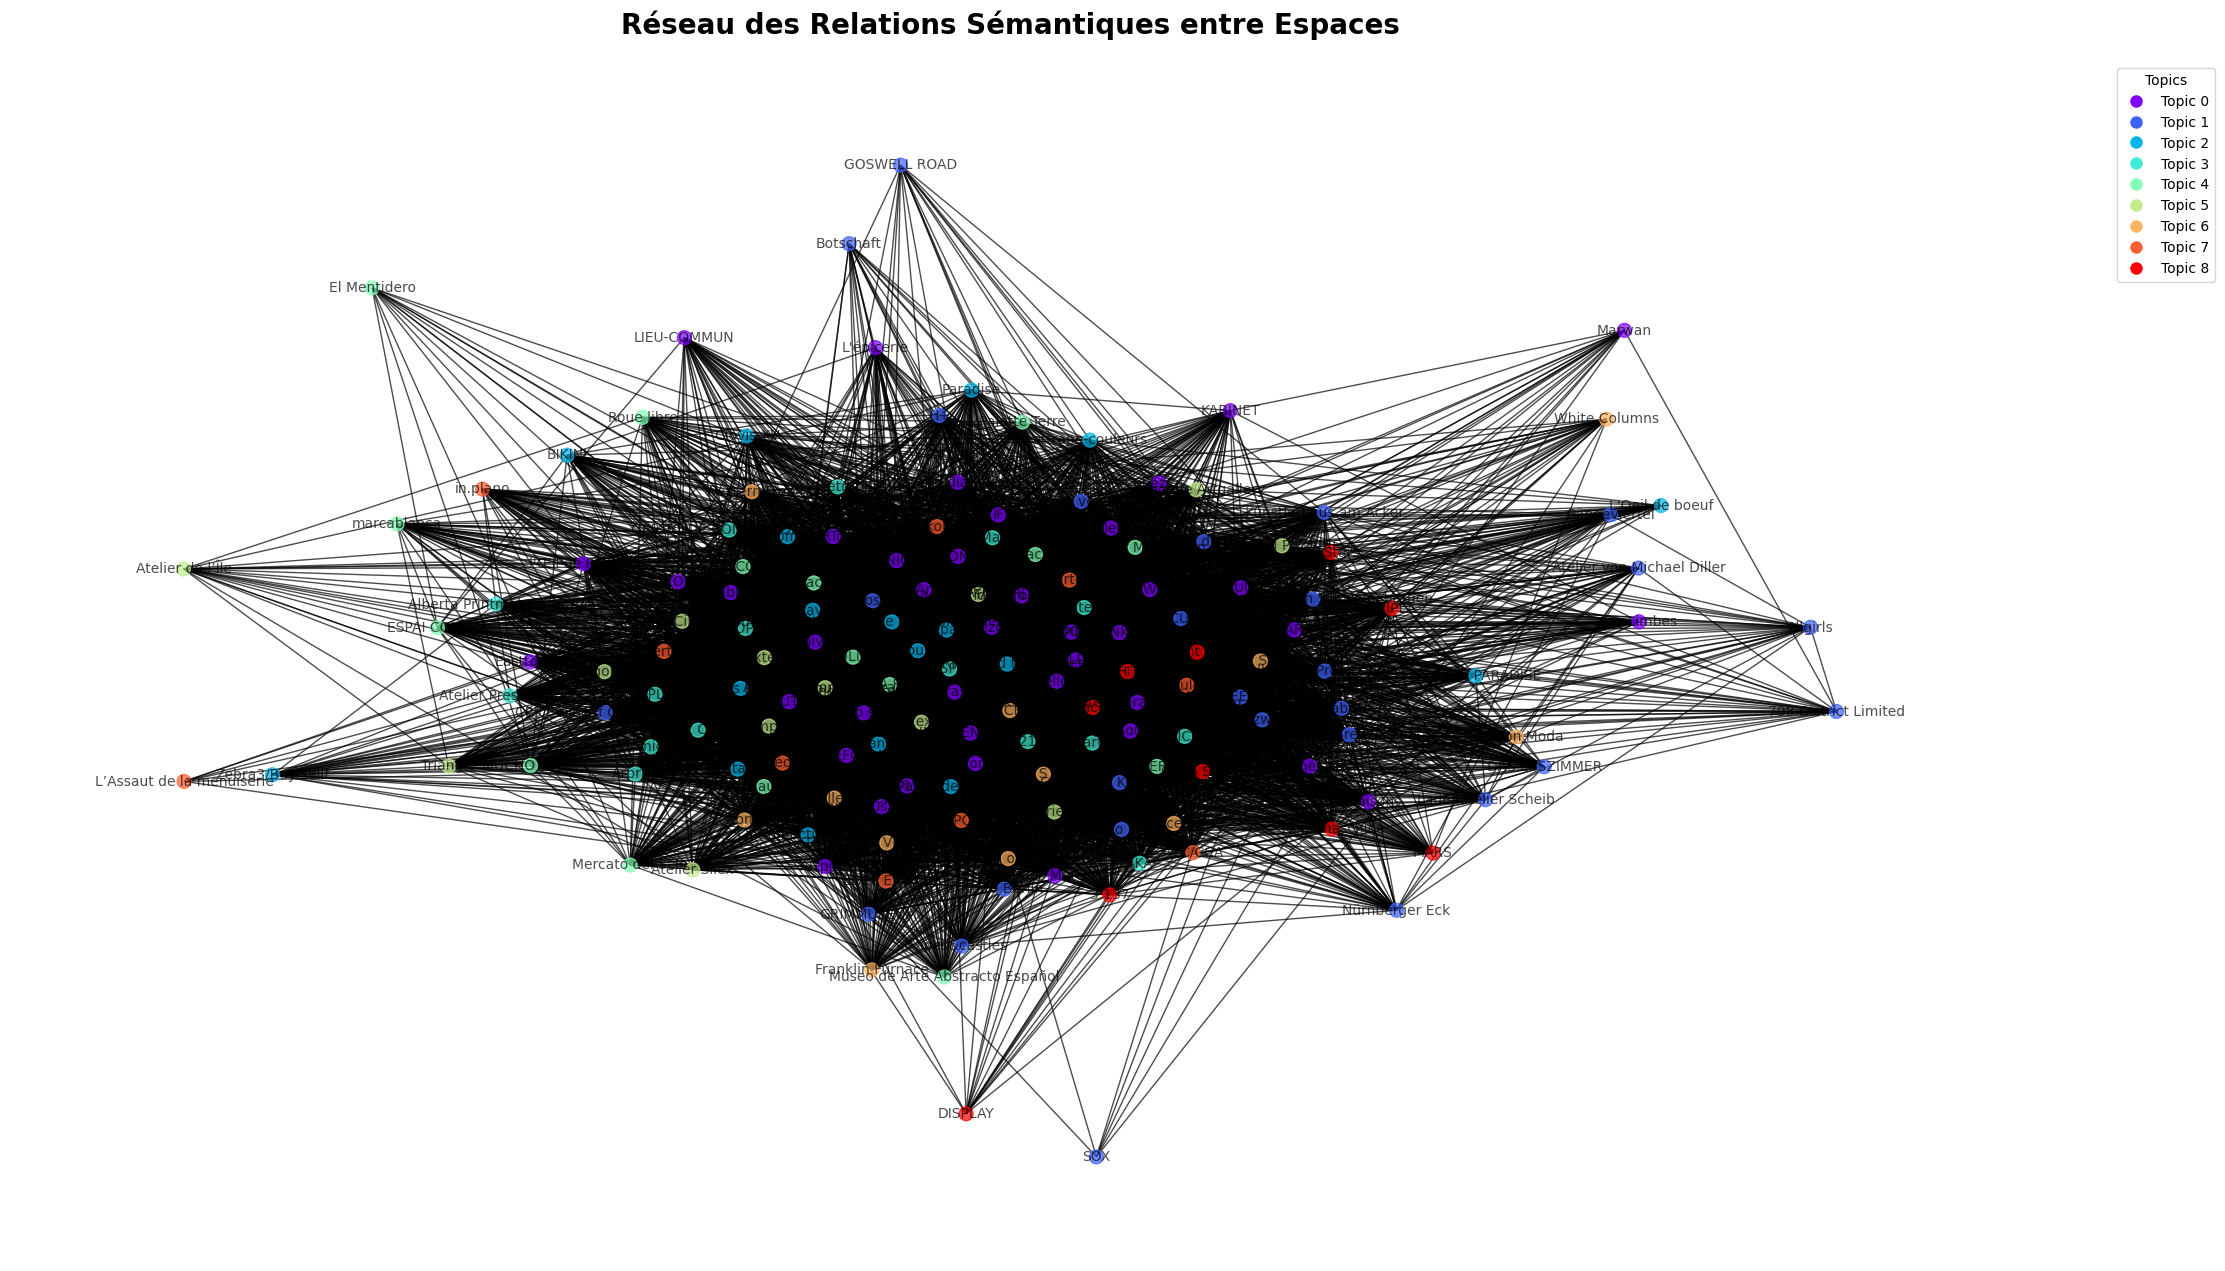


Statistiques du réseau:
Nombre de nœuds: 164
Nombre de connexions: 8369
Densité du réseau: 0.626


In [72]:
# Section 6 : Graphe des Relations Sémantiques
###########################################

# Filtrer les nœuds pour exclure les documents du topic -1
filtered_df = processed_df[processed_df['topic'] != -1]

# Création du graphe avec les données filtrées
G_filtered = nx.Graph()
embeddings_filtered = topic_model._extract_embeddings(filtered_df['texte'].tolist())
similarities_filtered = cosine_similarity(embeddings_filtered)

# Ajouter les nœuds
# Ajouter les nœuds
for i in range(len(filtered_df)):
    G_filtered.add_node(i, 
                        space_name=filtered_df['nom'].iloc[i],
                        topic=filtered_df['topic'].iloc[i])

# Ajouter les arêtes
threshold = 0.3 # Augmenté pour réduire la densité
for i in range(len(filtered_df)):
    for j in range(i+1, len(filtered_df)):
        if similarities_filtered[i,j] > threshold:
            G_filtered.add_edge(i, j, weight=similarities_filtered[i,j])


# Visualisation du réseau
plt.figure(figsize=(20, 12), facecolor='white')
pos = nx.spring_layout(G_filtered, k=1, iterations=50)

# Colorer les nœuds par topic
topics = [G_filtered.nodes[n]['topic'] for n in G_filtered.nodes()]
unique_topics = list(set(topics))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_topics)))

# Dessiner le graphe
nx.draw(G_filtered, pos,
       node_color=[colors[unique_topics.index(t)] for t in topics],
       node_size=100,
       alpha=0.7,
       with_labels=True,
       labels={i: filtered_df['nom'].iloc[i] for i in range(len(filtered_df))},  # Noms des espaces comme étiquettes
       font_size=10,  # Taille des étiquettes
       font_color='black')

# Ajouter la légende
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=colors[i], label=f'Topic {t}',
                            markersize=10)
                  for i, t in enumerate(unique_topics)]
plt.legend(handles=legend_elements, 
          title='Topics',
          bbox_to_anchor=(1.05, 1),
          loc='upper left')

# Titre et configuration finale
plt.title("Réseau des Relations Sémantiques entre Espaces",
         pad=20,
         fontsize=20,
         fontweight='bold',
         color = 'black')

plt.tight_layout()
plt.savefig('semantic_network.png', 
            dpi=300,
            bbox_inches='tight',
            facecolor='white')
plt.show()

# Afficher quelques statistiques sur le réseau
print("\nStatistiques du réseau:")
print(f"Nombre de nœuds: {G_filtered.number_of_nodes()}")
print(f"Nombre de connexions: {G_filtered.number_of_edges()}")
print(f"Densité du réseau: {nx.density(G_filtered):.3f}")

-  Chaque document(Espace) est représenté par un nœud dans le graphe.
-  Chaque document est associé à un topic,
-  les arêtel sont ajoutées entre les nœuds si la similarité entre deux documents est supérieure à un seuil (0.3 dans ce cas).
- Si deux documents (nœuds) sont très similaires, cela signifie qu'ils parlent de sujets proches ou ont des thématiques communes.



- graphe de relations sémantiques entre les documents en utilisant leurs embeddings et leurs similarités cosinus. Il visualise les connexions entre les documents similaires, les colore par topic et affiche des statistiques utiles sur le réseau, telles que le nombre de nœuds, le nombre d'arêtes et la densité du réseau.

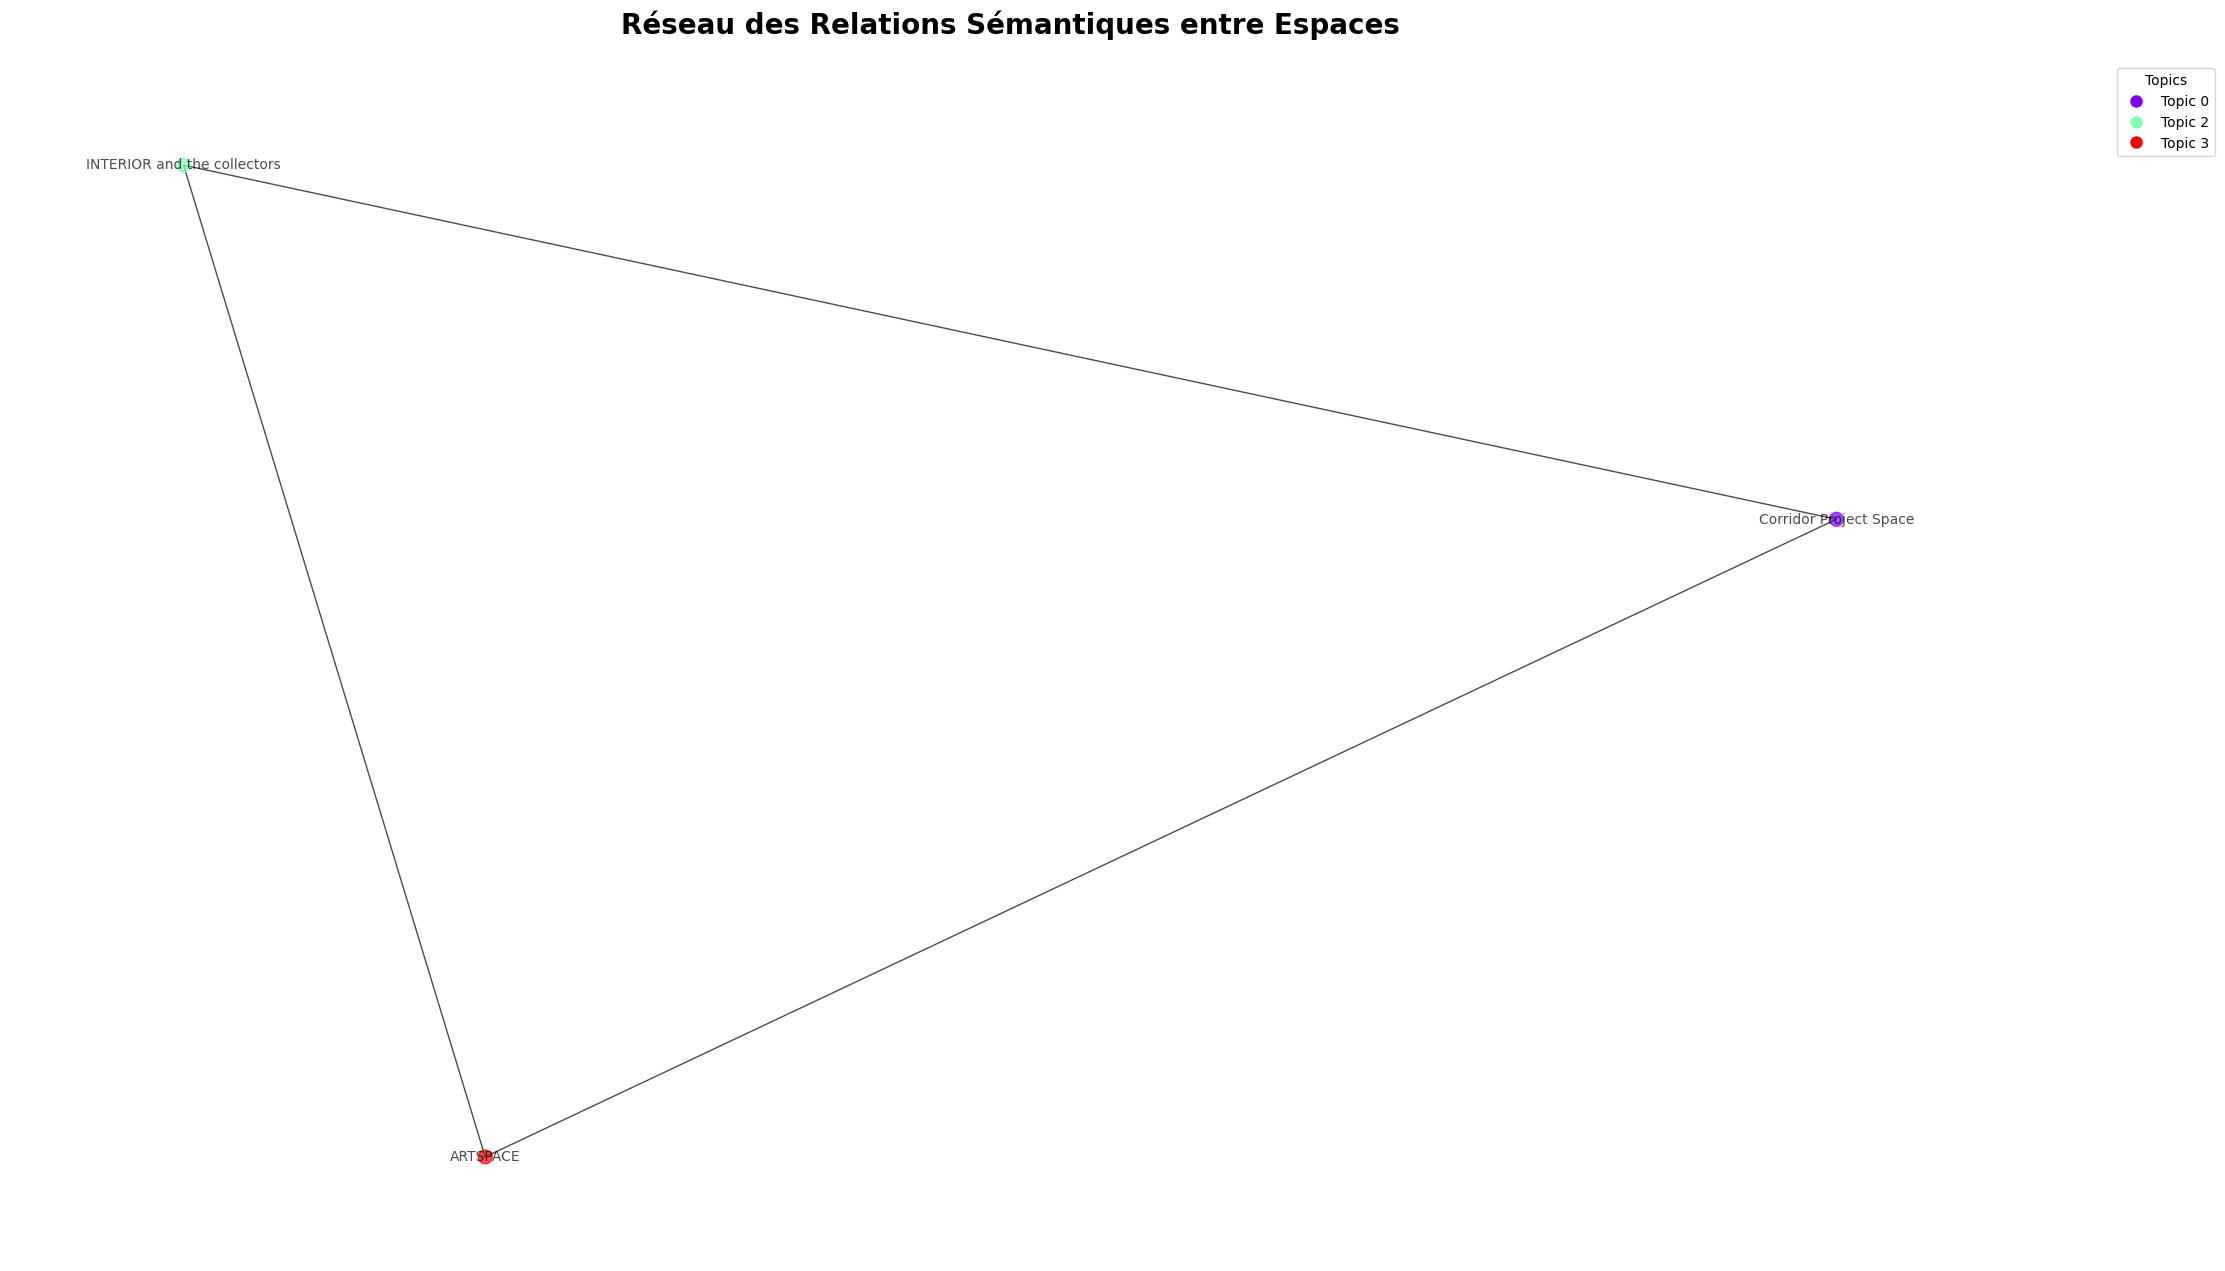


Statistiques du réseau:
Nombre de nœuds: 3
Nombre de connexions: 3
Densité du réseau: 1.000


In [76]:

# Section 6 : Graphe des Relations Sémantiques
###########################################

# Filtrer les nœuds pour exclure les documents du topic -1
filtered_df = processed_df[processed_df['topic'] != -1]

# Création du graphe avec les données filtrées
G_filtered = nx.Graph()
embeddings_filtered = topic_model._extract_embeddings(filtered_df['texte'].tolist())
similarities_filtered = cosine_similarity(embeddings_filtered)

# Ajouter les nœuds
for i, (nom, topic) in enumerate(zip(filtered_df['nom'], filtered_df['topic'])):
    G_filtered.add_node(i, space_name=nom, topic=topic)

# Ajouter les arêtes
threshold = 0.5  # Augmenté pour réduire la densité
for i in range(len(filtered_df)):
    for j in range(i + 1, len(filtered_df)):
        if similarities_filtered[i, j] > threshold:
            G_filtered.add_edge(i, j, weight=similarities_filtered[i, j])

# Supprimer les nœuds isolés (moins de 2 connexions)
isolated_nodes = [node for node, degree in dict(G_filtered.degree()).items() if degree < 50]
G_filtered.remove_nodes_from(isolated_nodes)

# Génération des positions après suppression des nœuds isolés
pos = nx.spring_layout(G_filtered, k=1, iterations=50)

# Vérifier que tous les nœuds dans `pos` sont bien présents dans `G_filtered`
valid_nodes = set(G_filtered.nodes())
pos = {n: pos[n] for n in valid_nodes if n in pos}

# Visualisation du réseau
plt.figure(figsize=(20, 12), facecolor='white')

# Colorer les nœuds par topic
topics = [G_filtered.nodes[n]['topic'] for n in G_filtered.nodes()]
unique_topics = list(set(topics))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_topics)))

# Dessiner le graphe
nx.draw(G_filtered, pos,
        node_color=[colors[unique_topics.index(G_filtered.nodes[n]['topic'])] for n in G_filtered.nodes()],
        node_size=100,
        alpha=0.7,
        with_labels=True,
        labels={n: G_filtered.nodes[n]['space_name'] for n in G_filtered.nodes()},
        font_size=10,
        font_color='black')

# Ajouter la légende
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=colors[i], label=f'Topic {t}',
                              markersize=10)
                   for i, t in enumerate(unique_topics)]
plt.legend(handles=legend_elements,
           title='Topics',
           bbox_to_anchor=(1.05, 1),
           loc='upper left')

# Titre et configuration finale
plt.title("Réseau des Relations Sémantiques entre Espaces",
          pad=20,
          fontsize=20,
          fontweight='bold',
          color='black')

plt.tight_layout()
plt.savefig('semantic_network.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white')
plt.show()

# Afficher quelques statistiques sur le réseau
print("\nStatistiques du réseau:")
print(f"Nombre de nœuds: {G_filtered.number_of_nodes()}")
print(f"Nombre de connexions: {G_filtered.number_of_edges()}")
print(f"Densité du réseau: {nx.density(G_filtered):.3f}")


In [66]:
import json

# Construire le dictionnaire des nœuds
nodes_data = [
    {
        "id": int(i),  # Convertir en int standard
        "name": str(G_filtered.nodes[i]["space_name"]),
        "topic": int(G_filtered.nodes[i]["topic"])  # Convertir topic en int
    }
    for i in G_filtered.nodes
]

# Construire le dictionnaire des liens (edges)
edges_data = [
    {
        "source": int(i),  # Convertir en int standard
        "target": int(j),
        "weight": float(G_filtered[i][j]["weight"])  # Convertir en float standard
    }
    for i, j in G_filtered.edges
]

# Créer la structure finale
graph_data = {
    "nodes": nodes_data,
    "links": edges_data
}

# Sauvegarde en JSON
with open("semantic_network.json", "w", encoding="utf-8") as f:
    json.dump(graph_data, f, indent=4, ensure_ascii=False)

print("✅ Fichier JSON enregistré : semantic_network.json")


✅ Fichier JSON enregistré : semantic_network.json



Exemple d'annotations générées :
Thème 0: events & media & cultural
Thème 1: activity & poetry & research
Thème 2: berlin & wall & strategy
Thème 3: printed & centre & organization
Thème 4: family & centre & france


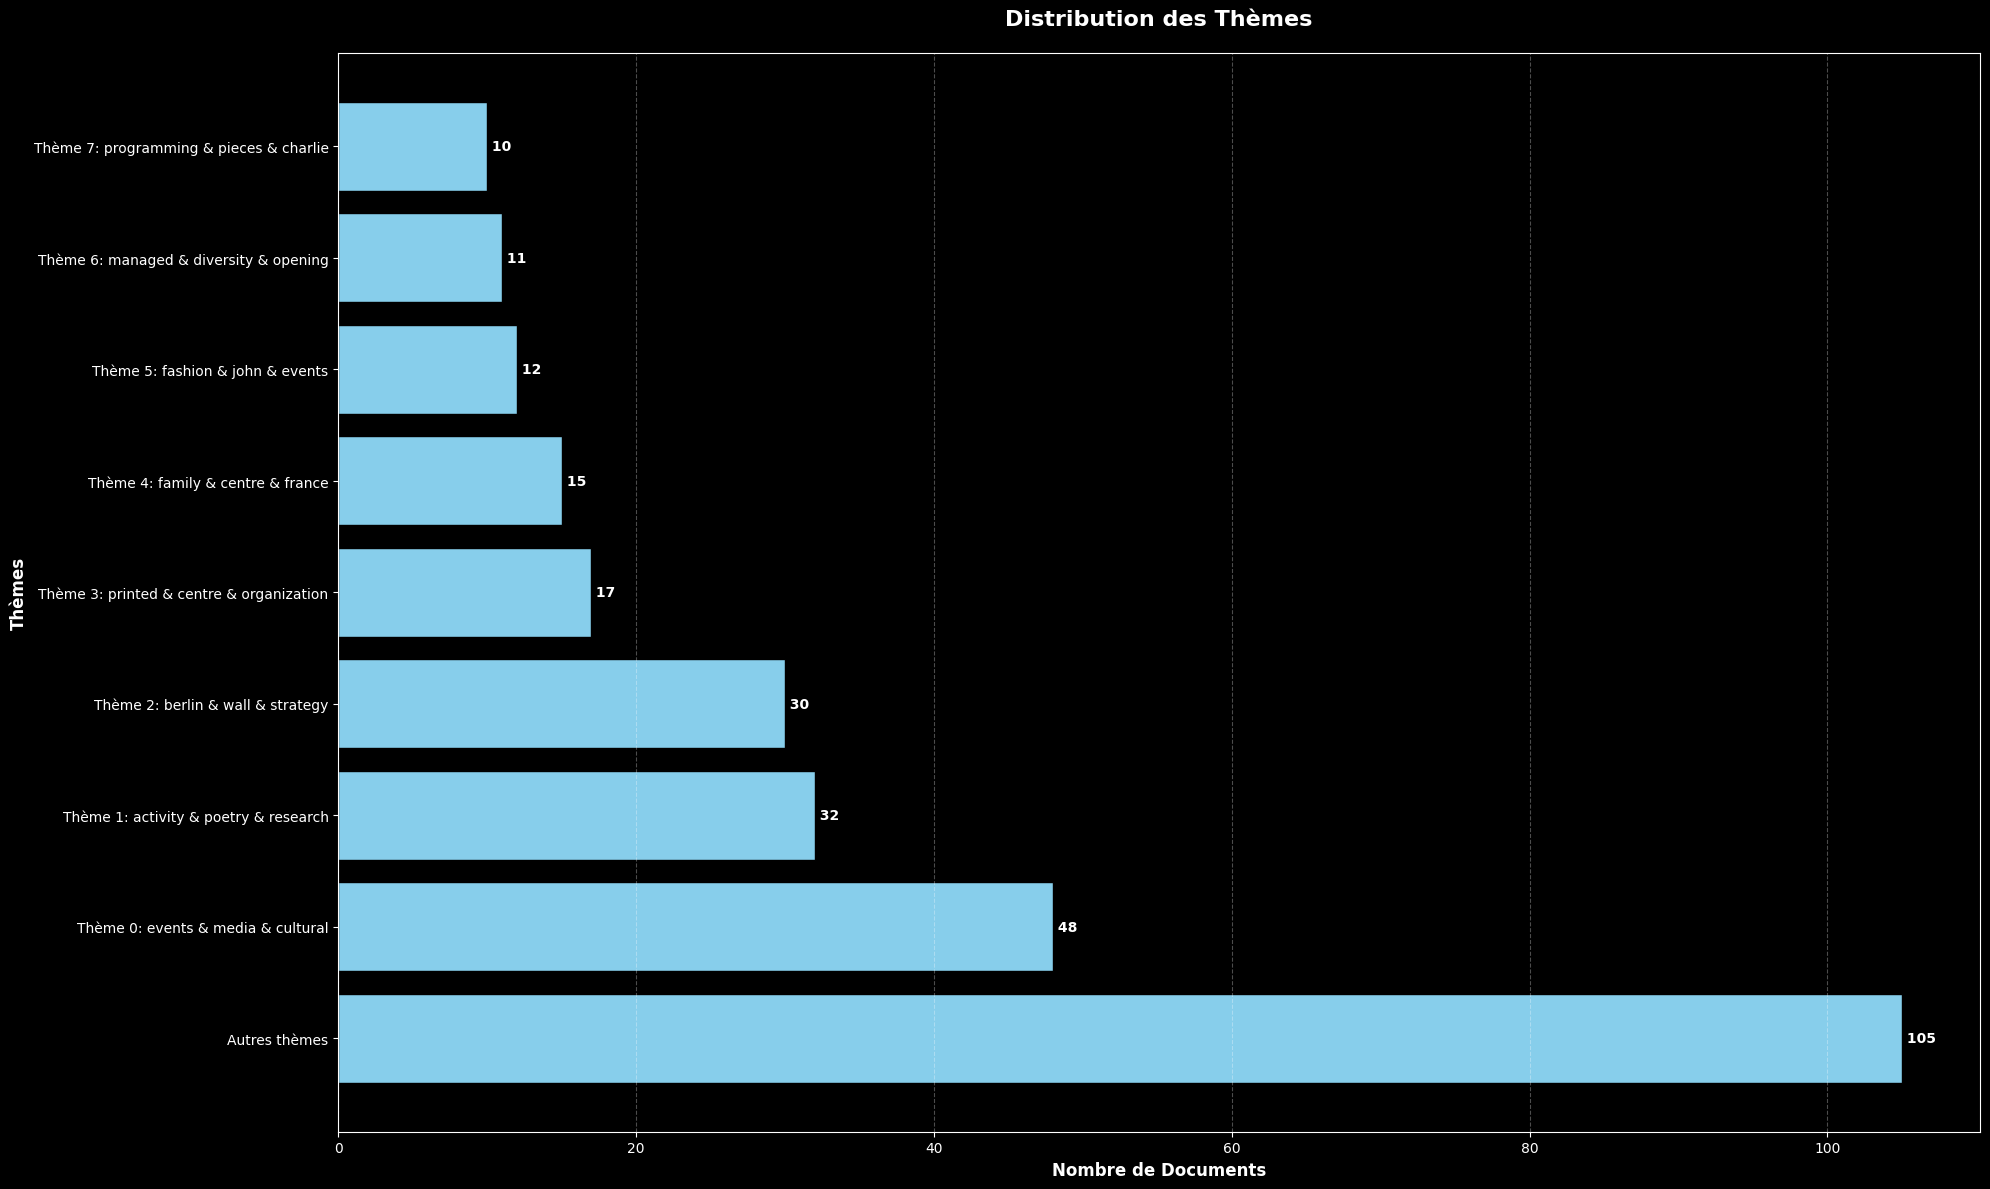

In [ ]:
# Section 7 : Annotations et Pipeline
###########################################
def generate_topic_annotations(topic_model, topics):
    """
    Génère des annotations descriptives pour chaque topic
    """
    annotations = {}
    for topic_id in set(topics):
        if topic_id != -1:
            # Obtenir les mots-clés du topic
            keywords = topic_model.get_topic(topic_id)
            # Générer une annotation basée sur les mots-clés principaux
            main_keywords = [word for word, _ in keywords[:3]]
            annotation = " & ".join(main_keywords)
            annotations[topic_id] = f"Thème {topic_id}: {annotation}"
    
    # Ajouter une annotation pour le topic -1 (outliers)
    annotations[-1] = "Autres thèmes"
    return annotations

def topic_annotation_pipeline(new_texts, topic_model, existing_annotations=None):
    """
    Pipeline pour appliquer les annotations à de nouveaux textes
    
    Parameters:
    -----------
    new_texts : list
        Liste des nouveaux textes à analyser
    topic_model : BERTopic
        Modèle BERTopic entraîné
    existing_annotations : dict, optional
        Annotations existantes à réutiliser
        
    Returns:
    --------
    DataFrame avec les résultats de l'analyse
    """
    # Transformer les nouveaux textes
    new_topics, new_probs = topic_model.transform(new_texts)
    
    # Utiliser les annotations existantes ou en générer de nouvelles
    if existing_annotations is None:
        annotations = generate_topic_annotations(topic_model, new_topics)
    else:
        annotations = existing_annotations
    
    # Créer un DataFrame avec les résultats
    results = pd.DataFrame({
        'texte': new_texts,
        'topic': new_topics,
        'annotation': [annotations.get(topic, "Autre") for topic in new_topics],
        'probabilite': [np.max(prob) for prob in new_probs]
    })
    
    return results

# Application des annotations au DataFrame existant
topic_annotations = generate_topic_annotations(topic_model, topics)
processed_df['annotation'] = processed_df['topic'].map(topic_annotations)

# Affichage des résultats
print("\nExemple d'annotations générées :")
for topic_id, annotation in list(topic_annotations.items())[:5]:
    print(f"{annotation}")

# Calculer les comptes d'annotations
annotation_counts = processed_df['annotation'].value_counts()

# Créer une figure avec une taille spécifique
plt.figure(figsize=(20, 12))

# Créer le graphique en barres horizontales
bars = plt.barh(range(len(annotation_counts)), annotation_counts.values, color='skyblue', edgecolor='black')

# Configurer les étiquettes de l'axe y
plt.yticks(range(len(annotation_counts)), annotation_counts.index, fontsize=10)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, i, f' {int(width)}', va='center', fontsize=10, fontweight='bold')

# Configurer les titres et labels
plt.title("Distribution des Thèmes", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Nombre de Documents", fontsize=12, fontweight='bold')
plt.ylabel("Thèmes", fontsize=12, fontweight='bold')

# Ajouter une grille légère
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Ajuster la mise en page
plt.tight_layout()

# Sauvegarder et afficher
plt.savefig('distribution_themes.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')
plt.show()

# Section des Annotations retenues

In [ ]:
# Générer des annotations à partir des topics
topic_annotations = generate_topic_annotations(topic_model, topics)

# Convertir en format adapté pour l'interface
annotations_ui = []
for topic_id, annotation_text in topic_annotations.items():
    if topic_id != -1:  # Exclure les outliers si nécessaire
        color = f"#{random.randint(0, 255):02x}{random.randint(0, 255):02x}{random.randint(0, 255):02x}"
        count = len(processed_df[processed_df['topic'] == topic_id])
        annotations_ui.append({
            "id": int(topic_id),
            "name": annotation_text,
            "color": color,
            "count": count
        })

# Sauvegarder en JSON
with open("annotations.json", "w", encoding="utf-8") as f:
    json.dump(annotations_ui, f, ensure_ascii=False, indent=4)

print("Fichier JSON 'annotations.json' généré avec succès.")

In [ ]:
#Enregistrer les annations pour étiqueter" ou classifier les documents
#Enregistrer en json 



In [ ]:
# Section 8 : Export des Résultats
###########################################

# Préparer le DataFrame final avec toutes les informations importantes
final_results = pd.DataFrame({
    'nom_espace': processed_df['nom'],
    'texte': processed_df['texte'],
    'topic': processed_df['topic'],
    'annotation': processed_df['annotation'],
    'probabilite': processed_df['topic_probability']
})

# Ajouter les mots-clés pour chaque espace
keywords_dict = {}
for idx, row in final_results.iterrows():
    if row['topic'] != -1:
        keywords = topic_model.get_topic(row['topic'])
        keywords_dict[idx] = ', '.join([word for word, _ in keywords[:5]])
    else:
        keywords_dict[idx] = 'Non classifié'

final_results['mots_cles'] = pd.Series(keywords_dict)

# Sauvegarder les résultats
final_results.to_excel("resultats_complets.xlsx", index=False)
final_results[['nom_espace', 'topic', 'annotation', 'mots_cles']].to_csv("resume_classification.csv", index=False)

# Afficher un résumé détaillé avec pandas
print("\n=== RÉSUMÉ DE L'ANALYSE ===")
print(f"\nNombre total d'espaces analysés : {len(final_results)}")
print(f"Nombre de topics identifiés : {len(topic_annotations)}")

print("\n=== DISTRIBUTION DES TOPICS ===")
topic_dist = final_results['topic'].value_counts().sort_index()
display(topic_dist.to_frame(name='Nombre d\'espaces'))

print("\n=== APERÇU DES RÉSULTATS PAR TOPIC ===")
for topic in sorted(final_results['topic'].unique()):
    if topic != -1:
        print(f"\nTopic {topic}:")
        subset = final_results[final_results['topic'] == topic][['nom_espace', 'annotation', 'mots_cles']]
        display(subset.head(3))
        print("-" * 100)

# Créer un résumé statistique
summary_stats = pd.DataFrame({
    'Métrique': [
        'Nombre total d\'espaces',
        'Nombre de topics',
        'Espaces non classifiés',
        'Topic le plus fréquent',
        'Taille moyenne par topic'
    ],
    'Valeur': [
        len(final_results),
        len(topic_annotations) - 1,  # -1 pour exclure le topic -1
        len(final_results[final_results['topic'] == -1]),
        f"Topic {topic_dist.index[0]} ({topic_dist.iloc[0]} espaces)",
        f"{len(final_results) / (len(topic_annotations) - 1):.1f} espaces"
    ]
})

print("\n=== STATISTIQUES GLOBALES ===")
display(summary_stats)

# Sauvegarder le modèle
import joblib
joblib.dump(topic_model, 'model_bertopic.pkl')
print("\nModèle sauvegardé sous 'model_bertopic.pkl'")


=== RÉSUMÉ DE L'ANALYSE ===

Nombre total d'espaces analysés : 280
Nombre de topics identifiés : 9

=== DISTRIBUTION DES TOPICS ===


,Nombre d'espaces
topic,
-1,105
0,48
1,32
2,30
3,17
4,15
5,12
6,11
7,10



=== APERÇU DES RÉSULTATS PAR TOPIC ===

Topic 0:


,nom_espace,annotation,mots_cles
1,/ 77,Thème 0: events & media & cultural,"events, media, cultural, platform, local"
8,KINGS Artist Run,Thème 0: events & media & cultural,"events, media, cultural, platform, local"
11,Artpool,Thème 0: events & media & cultural,"events, media, cultural, platform, local"


----------------------------------------------------------------------------------------------------

Topic 1:


,nom_espace,annotation,mots_cles
2,Immanence,Thème 1: activity & poetry & research,"activity, poetry, research, milan, activities"
3,Lieu d'exposition en voie de déplacement (LEVD),Thème 1: activity & poetry & research,"activity, poetry, research, milan, activities"
27,Museo de Arte Abstracto Español,Thème 1: activity & poetry & research,"activity, poetry, research, milan, activities"


----------------------------------------------------------------------------------------------------

Topic 2:


,nom_espace,annotation,mots_cles
7,H+,Thème 2: berlin & wall & strategy,"berlin, wall, strategy, different, future"
14,Nürnberger Eck,Thème 2: berlin & wall & strategy,"berlin, wall, strategy, different, future"
25,Bell Street Project Space,Thème 2: berlin & wall & strategy,"berlin, wall, strategy, different, future"


----------------------------------------------------------------------------------------------------

Topic 3:


,nom_espace,annotation,mots_cles
13,GERTRUDE CONTEMPORARY,Thème 3: printed & centre & organization,"printed, centre, organization, community, profit"
91,"Printed Matter, Inc.",Thème 3: printed & centre & organization,"printed, centre, organization, community, profit"
109,Arprim,Thème 3: printed & centre & organization,"printed, centre, organization, community, profit"


----------------------------------------------------------------------------------------------------

Topic 4:


,nom_espace,annotation,mots_cles
35,Angle art contemporain,Thème 4: family & centre & france,"family, centre, france, residences, atelier"
36,Triangle,Thème 4: family & centre & france,"family, centre, france, residences, atelier"
63,Diagonale,Thème 4: family & centre & france,"family, centre, france, residences, atelier"


----------------------------------------------------------------------------------------------------

Topic 5:


,nom_espace,annotation,mots_cles
5,BLINDSIDE,Thème 5: fashion & john & events,"fashion, john, events, books, performance"
16,TCB,Thème 5: fashion & john & events,"fashion, john, events, books, performance"
19,West Space,Thème 5: fashion & john & events,"fashion, john, events, books, performance"


----------------------------------------------------------------------------------------------------

Topic 6:


,nom_espace,annotation,mots_cles
34,Open Space,Thème 6: managed & diversity & opening,"managed, diversity, opening, performance, vict..."
57,Espace 29,Thème 6: managed & diversity & opening,"managed, diversity, opening, performance, vict..."
76,Wohnmaschine,Thème 6: managed & diversity & opening,"managed, diversity, opening, performance, vict..."


----------------------------------------------------------------------------------------------------

Topic 7:


,nom_espace,annotation,mots_cles
6,Rogertator,Thème 7: programming & pieces & charlie,"programming, pieces, charlie, cultural, jean"
9,Quellkollektiv,Thème 7: programming & pieces & charlie,"programming, pieces, charlie, cultural, jean"
31,Néon,Thème 7: programming & pieces & charlie,"programming, pieces, charlie, cultural, jean"


----------------------------------------------------------------------------------------------------

=== STATISTIQUES GLOBALES ===


,Métrique,Valeur
0,Nombre total d'espaces,280
1,Nombre de topics,8
2,Espaces non classifiés,105
3,Topic le plus fréquent,Topic -1 (105 espaces)
4,Taille moyenne par topic,35.0 espaces



Modèle sauvegardé sous 'model_bertopic.pkl'
